In [84]:
"""
Data Manipulation and Visualization Libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

"""
Datetime Libraries
"""
from datetime import datetime

"""
Modelling Libraries
"""
import joblib
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# set period under observation
start_date = datetime(2022, 7, 1)
end_date = datetime(2024, 5, 31)
# end_date = datetime.today() - relativedelta(months=2)

## EDA

In [103]:
# read crude price data
brent_oil_price = pd.read_csv('DCOILBRENTEU.csv')
brent_oil_price['DATE'] = pd.to_datetime(brent_oil_price['DATE'])
brent_oil_price = brent_oil_price[(brent_oil_price['DATE'] > start_date) & (brent_oil_price['DATE'] < end_date)]

brent_oil_price.columns=['date', 'price']
brent_oil_price.set_index('date', inplace=True)

brent_oil_price.head()

,price
date,
2022-07-04,121.80
2022-07-05,110.49
2022-07-06,108.54
2022-07-07,113.40
2022-07-08,113.95


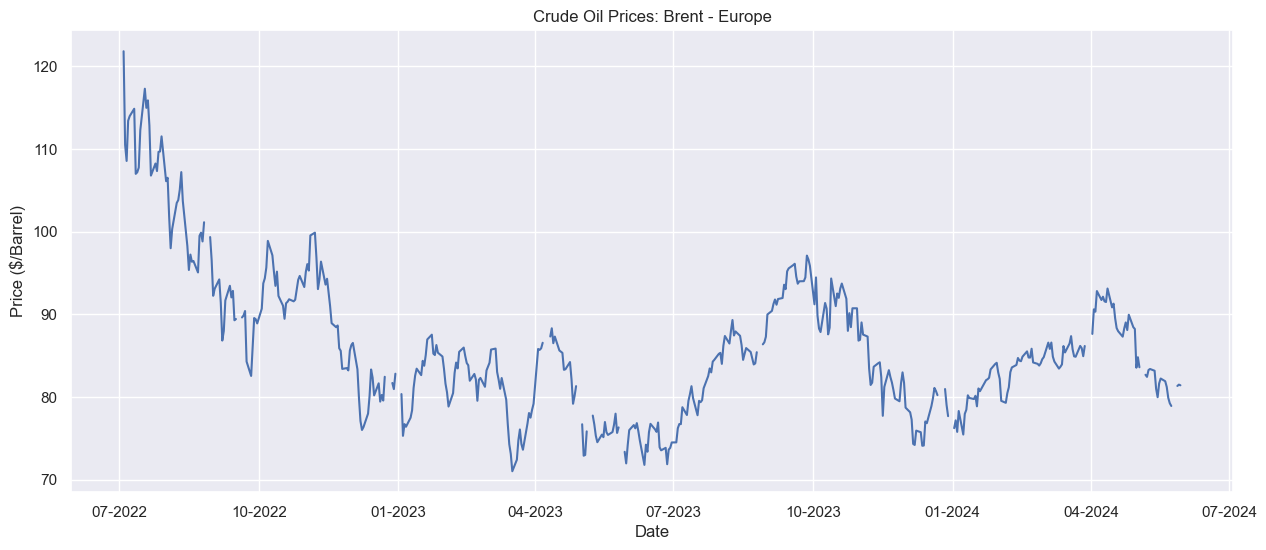

In [114]:
# Plot crude price 
sns.set_theme()
plt.figure(figsize=(15, 6))
plt.plot(brent_oil_price)
plt.title('Crude Oil Prices: Brent - Europe')
plt.xlabel("Date")
plt.ylabel("Price ($/Barrel)")

# Set x-axis to 3-month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))

plt.show()

In [118]:
# read twitter sentiment data 
tweets_sentiment = pd.read_csv('tweets_sentiment.csv', index_col='Unnamed: 0',  lineterminator='\n')

# compute tweet sentiment score and label
tweets_sentiment['sentiment_score'] = tweets_sentiment['Positive'] - tweets_sentiment['Negative']
tweets_sentiment['label'] = tweets_sentiment[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)\
                                .map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

# read twitter topic data 
tweets_topic = pd.read_csv('tweets_topic.csv', index_col='Unnamed: 0')

# merge twitter sentiment and topic into one dataframe
tweets_df = tweets_sentiment.merge(tweets_topic, how='inner', on='id', suffixes=('', '_copy'))
tweets_df.drop(columns=[col for col in tweets_df.columns if col.endswith('_copy')], inplace=True)

# filter for tweets within date range
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df = tweets_df[(tweets_df['date'] >= start_date) & (tweets_df['date'] <= end_date)]
tweets_df.tail()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription,Positive,Negative,Neutral,sentiment_score,label,topic
37685,1730343584572867060,2023-11-30,en,"At least based on today, can't say there's muc...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.044599,0.062963,0.892437,-0.018364,0,3
37686,1730185032914829401,2023-11-30,en,"Is $XOM's ""Death Cross"" a reason for #Energy b...",1209952412338991104,TheFortuneTell5,The Fortune Teller @ Wheel of Fortune,Market Beast 30+yrs\nInvestment/portfolio mana...,0.053212,0.118022,0.828767,-0.064810,0,3
37687,1730352191548883361,2023-11-30,en,#OOTT #WTI As the #OPEC+ conspiracy collapsed ...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.311486,0.573089,0.115425,-0.261603,-1,0
37688,1730348517313466869,2023-11-30,en,#OOTT #WTI [W1]#OPEC+ got clubbed after its pa...,3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.025245,0.888074,0.086681,-0.862829,-1,0
37689,1730343562728944032,2023-11-30,en,"#OOTT #WTI ""For now, the outcome does not live...",3066855883,DB_WTI,WTI Trading Group- 🇺🇸 US Crude Oil Trader🛢️🌎,💰 The Best Incubator for Future Winning #US #C...,0.023566,0.911276,0.065159,-0.887710,-1,0


In [119]:
# Group tweets by date and calculate average sentiment
daily_sentiment = tweets_df.loc[:, ['date', 'label', 'sentiment_score']]
daily_sentiment = daily_sentiment.groupby(['date']).mean()

daily_sentiment.columns = [f'{col}_0' for col in daily_sentiment.columns]
daily_sentiment.head()

,label_0,sentiment_score_0
date,,
2022-07-01,-0.180556,-0.133128
2022-07-02,0.333333,0.212321
2022-07-03,-0.264706,-0.217177
2022-07-04,-0.160714,-0.123233
2022-07-05,-0.163934,-0.139811


In [120]:
# Group by date and topic and calculate average sentiment
daily_topic_sentiment = tweets_df.loc[:, ['date', 'label','topic', 'sentiment_score']]
daily_topic_sentiment['topic'] = daily_topic_sentiment['topic']+1
daily_topic_sentiment = daily_topic_sentiment.groupby(['date', 'topic']).mean()

# Unstack 'topic' to become columns
daily_topic_sentiment = daily_topic_sentiment.unstack(level='topic')

# Flatten the column MultiIndex resulting from unstack
daily_topic_sentiment.columns = daily_topic_sentiment.columns.map('{0[0]}_{0[1]}'.format) 

daily_topic_sentiment.head()

,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,
2022-07-01,-0.380952,0.000000,-0.263158,0.000000,-0.323286,0.019052,-0.196079,0.037853
2022-07-02,0.000000,0.000000,1.000000,1.000000,-0.070201,-0.004047,0.648673,0.839905
2022-07-03,-0.333333,-0.190476,-0.333333,-0.214286,-0.283336,-0.173141,-0.271328,-0.135003
2022-07-04,-0.095238,-0.187500,-0.375000,-0.090909,-0.129210,-0.082532,-0.274846,-0.060758
2022-07-05,-0.250000,-0.090909,0.000000,0.000000,-0.233597,-0.049497,0.061214,-0.010699


In [121]:
# merge daily sentiment by topic and overall into one dataframe
daily_sentiment = pd.concat([daily_sentiment, daily_topic_sentiment], axis=1)
daily_sentiment.head()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2022-07-01,-0.180556,-0.133128,-0.380952,0.000000,-0.263158,0.000000,-0.323286,0.019052,-0.196079,0.037853
2022-07-02,0.333333,0.212321,0.000000,0.000000,1.000000,1.000000,-0.070201,-0.004047,0.648673,0.839905
2022-07-03,-0.264706,-0.217177,-0.333333,-0.190476,-0.333333,-0.214286,-0.283336,-0.173141,-0.271328,-0.135003
2022-07-04,-0.160714,-0.123233,-0.095238,-0.187500,-0.375000,-0.090909,-0.129210,-0.082532,-0.274846,-0.060758
2022-07-05,-0.163934,-0.139811,-0.250000,-0.090909,0.000000,0.000000,-0.233597,-0.049497,0.061214,-0.010699


In [143]:
# Find percentage of dates without a certain topic
print('% days with no tweets by topic')
print(round(daily_topic_sentiment.isna().sum() * 100 / len(daily_topic_sentiment), 2))

% days with no tweets by topic
label_1              0.00
label_2              0.43
label_3              0.43
label_4              0.57
sentiment_score_1    0.00
sentiment_score_2    0.43
sentiment_score_3    0.43
sentiment_score_4    0.57
dtype: float64


In [148]:
# Impute empty sentiment scores & labels with 0
features_df = daily_sentiment.fillna(0)

# Compute 7-day rolling average label & sentiment score
features_df = features_df.rolling(window=7).mean()
features_df.tail()

,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,
2024-05-27,-0.175591,-0.129427,-0.266826,0.092965,-0.186134,-0.123016,-0.250305,0.119174,-0.135923,-0.059630
2024-05-28,-0.130983,-0.101295,-0.169547,0.140584,-0.200420,-0.099206,-0.172202,0.124708,-0.133484,-0.043741
2024-05-29,-0.094890,-0.076828,-0.118527,0.133163,-0.133193,-0.084921,-0.117914,0.102768,-0.082155,-0.049314
2024-05-30,-0.074111,-0.064200,-0.109173,0.151020,-0.113550,-0.016893,-0.115058,0.098831,-0.064777,0.002360
2024-05-31,-0.061720,-0.051545,-0.110364,0.133163,0.017402,-0.045465,-0.115020,0.067778,0.065372,-0.001629


In [149]:
# merge price and features into one dataframe
df = pd.merge(brent_oil_price, features_df, left_index=True, right_index=True)
df.dropna(inplace=True)
df.head()

,price,label_0,sentiment_score_0,label_1,label_2,label_3,label_4,sentiment_score_1,sentiment_score_2,sentiment_score_3,sentiment_score_4
date,,,,,,,,,,,
2022-07-07,113.40,-0.092316,-0.086901,-0.188100,-0.120555,-0.011800,0.083488,-0.190777,-0.078725,-0.002572,0.071537
2022-07-08,113.95,-0.083189,-0.087374,-0.133678,-0.156269,0.001984,0.063080,-0.154155,-0.116261,0.001749,0.053397
2022-07-11,114.85,-0.122250,-0.115398,-0.129121,-0.182772,-0.103458,-0.043697,-0.149743,-0.138650,-0.068767,-0.043274
2022-07-12,106.98,-0.129643,-0.116865,-0.141026,-0.190193,-0.046315,-0.100840,-0.155559,-0.131345,-0.052966,-0.074022
2022-07-13,107.17,-0.113235,-0.104410,-0.123234,-0.148526,-0.046315,-0.092723,-0.136242,-0.109364,-0.059824,-0.067986


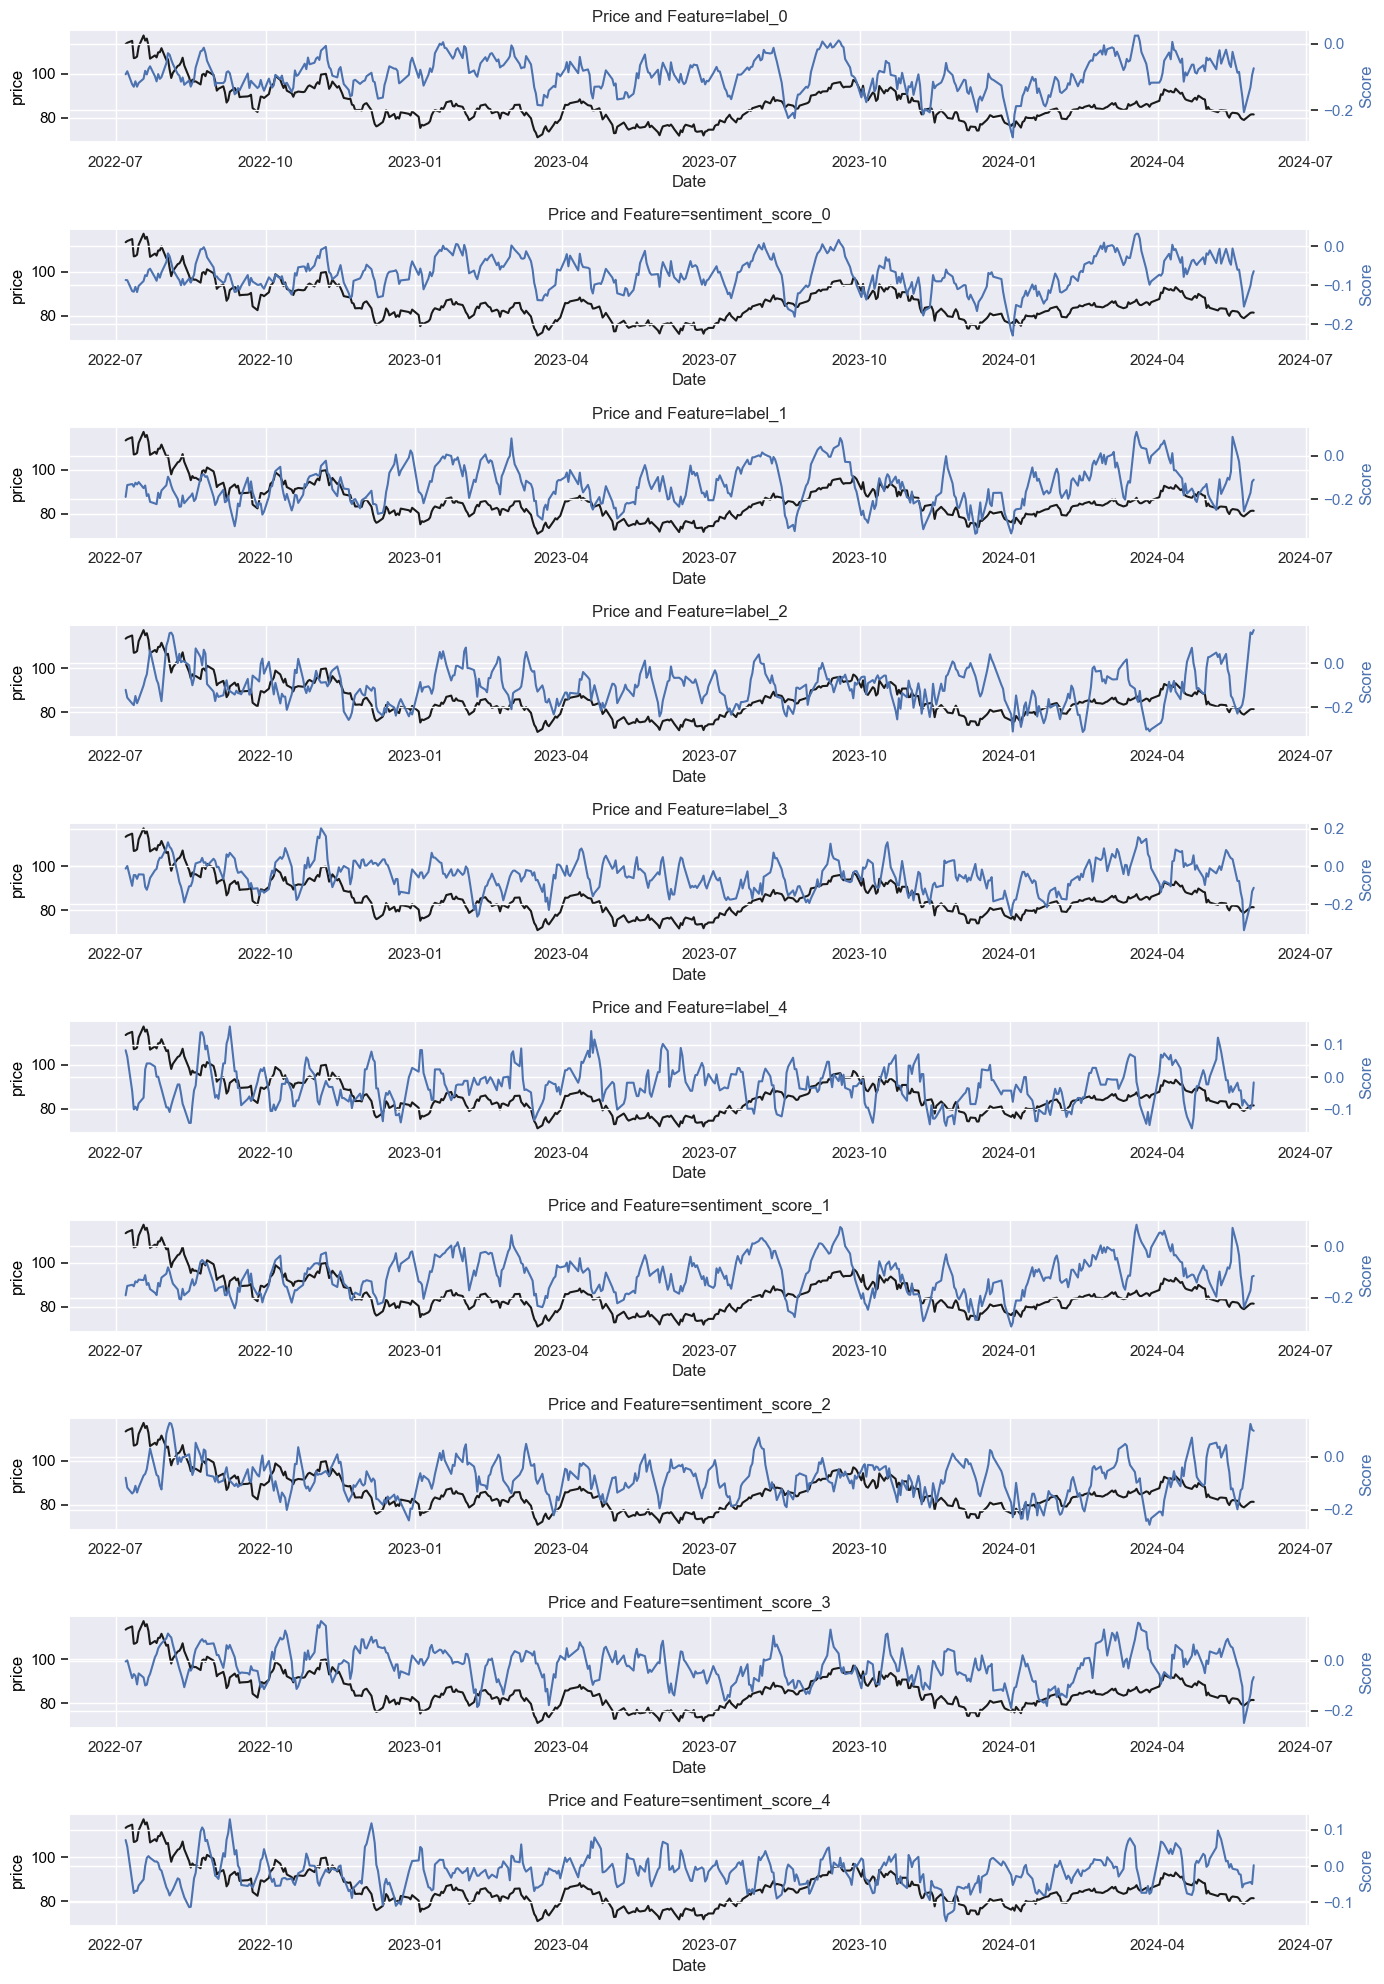

In [152]:
# Create subplots of pruce and sentiment score
fig, axs = plt.subplots(features_df.shape[1], 1, figsize=(14, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each feature against the target on different y-axes
for i in range(1, df.shape[1]):
    col = df.columns[i]
    ax1 = axs[i-1]
    ax2 = ax1.twinx()
    
    ax1.plot(df['price'], 'k-', label='Price')
    ax2.plot(df[col], 'b-', label=f'Topic {col}')
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('price', color='black')
    ax2.set_ylabel('Score', color='b')
    
    ax1.tick_params(axis='y', labelcolor='black')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # ax1.legend(loc='upper left')
    # ax2.legend(loc='upper right')
    ax1.set_title(f'Price and Feature={col}')

# Adjust layout
plt.tight_layout()
plt.show()

## Stationarity Check

In [158]:
# Define helper function to check for stationarity
def check_stationarity(df, column, lags, conf_level=0.05):
    # Drop NAs if any
    df = df.dropna(subset=column)

    # Plot acf 
    plot_acf(df[column], lags=lags)
    plt.title(f"Autocorrelation Function (ACF) - {column}")
    plt.xlabel("Lags")
    plt.ylabel("ACF Value")
    plt.show()

    # Compute adf test statistic
    adftest = adfuller(df[column], maxlag=lags, autolag='AIC', regression='ct')
    if adftest[1] < conf_level:
        print("ADF Test Conclusion: Stationary")
    else:
        print("ADF Test Conclusion: Non-stationary")
    print("------------------------------------")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print(f"Note: If P-Value is smaller than {conf_level}, we reject the null hypothesis and the series is stationary")
    
    return 

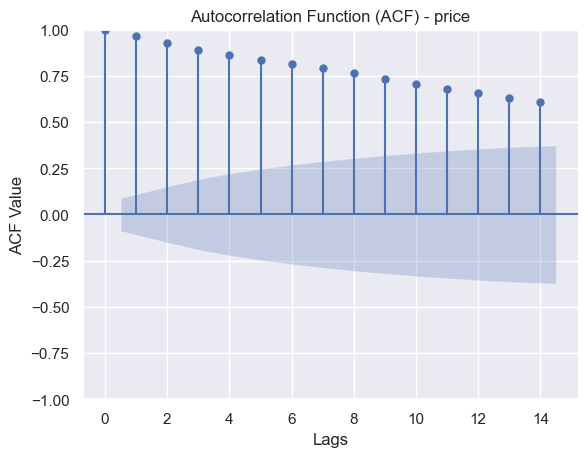

ADF Test Conclusion: Non-stationary
------------------------------------
ADF-Statistic: -2.9025231993737717
P-Value: 0.16140059515878052
Number of lags: 5
Number of observations: 472
Critical Values: {'1%': -3.9780791758236447, '5%': -3.419832685881194, '10%': -3.132545796894096}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [159]:
check_stationarity(df, 'price', 14)

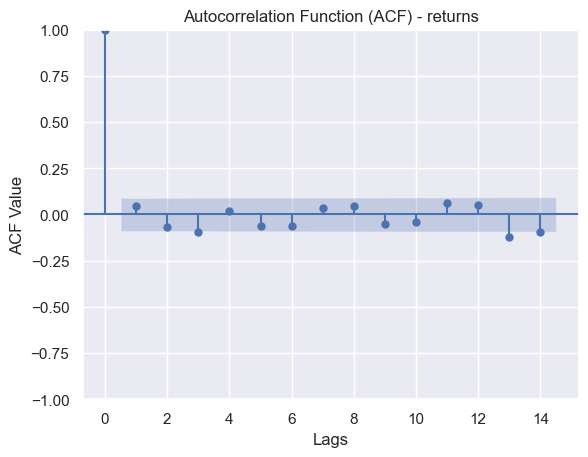

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -11.01585874133882
P-Value: 2.0766640062607016e-17
Number of lags: 4
Number of observations: 472
Critical Values: {'1%': -3.9780791758236447, '5%': -3.419832685881194, '10%': -3.132545796894096}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [160]:
# Calculate crude returns
df['returns'] = df['price'].pct_change(1)
check_stationarity(df, 'returns', 14)

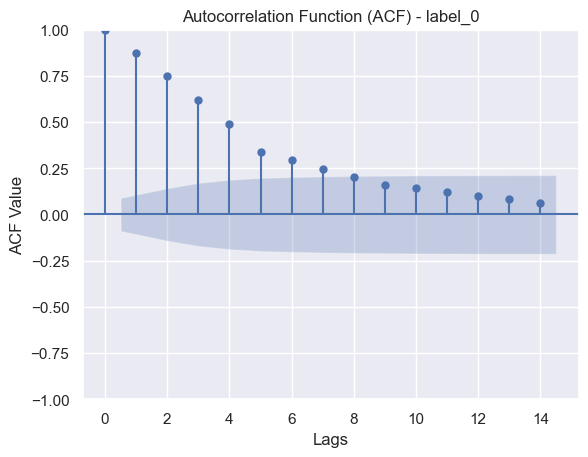

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.267521298524593
P-Value: 0.00353204474213152
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


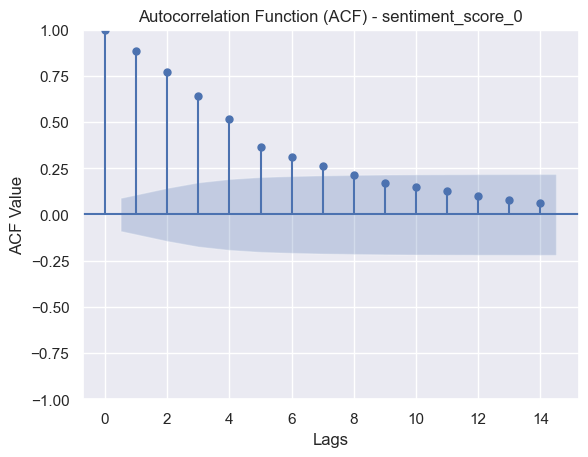

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.498378600068581
P-Value: 0.0015187627259275307
Number of lags: 11
Number of observations: 466
Critical Values: {'1%': -3.978329489428181, '5%': -3.419953518250008, '10%': -3.1326167935758216}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


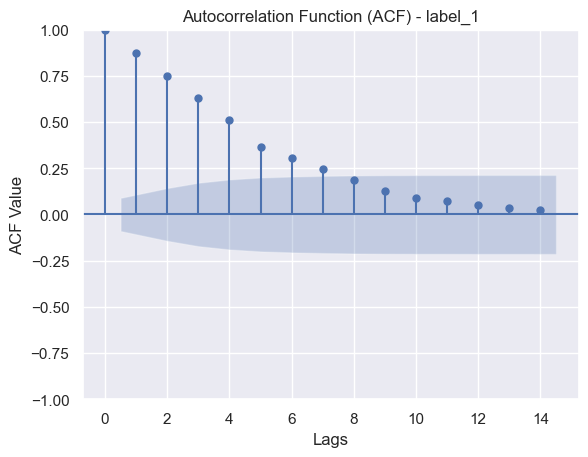

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.498297822554434
P-Value: 0.0015192246719401585
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


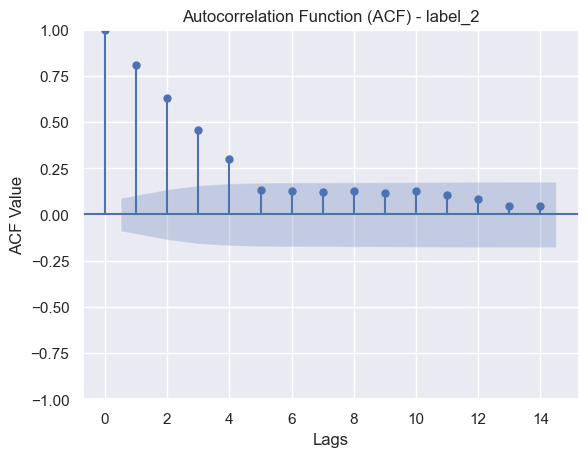

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.405743884262903
P-Value: 0.0021439583981794096
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


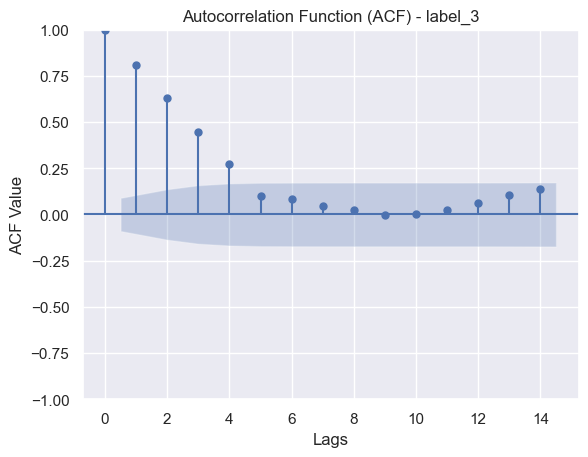

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.558981374925329
P-Value: 0.0012068921972590004
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


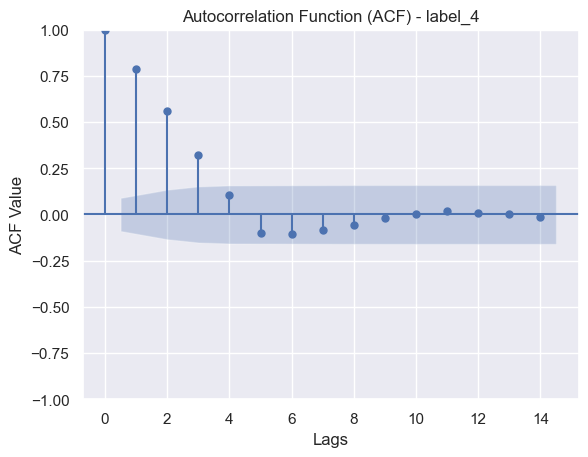

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.434540560288605
P-Value: 3.10003743866803e-05
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


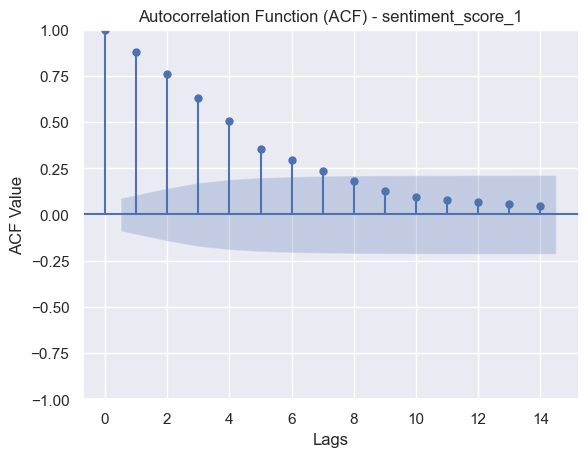

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.3960627786837305
P-Value: 0.0022215780541333173
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


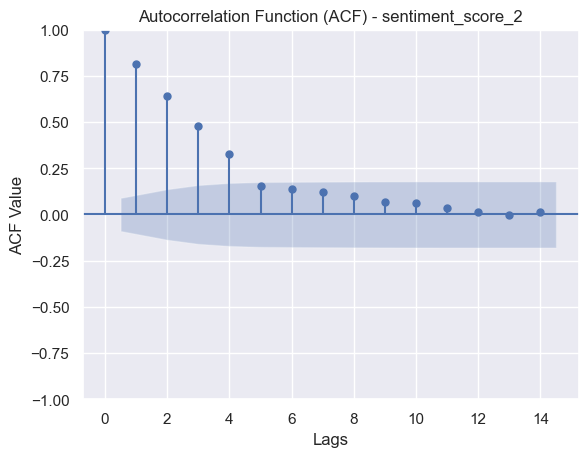

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.694546022462903
P-Value: 0.0007131386369350023
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


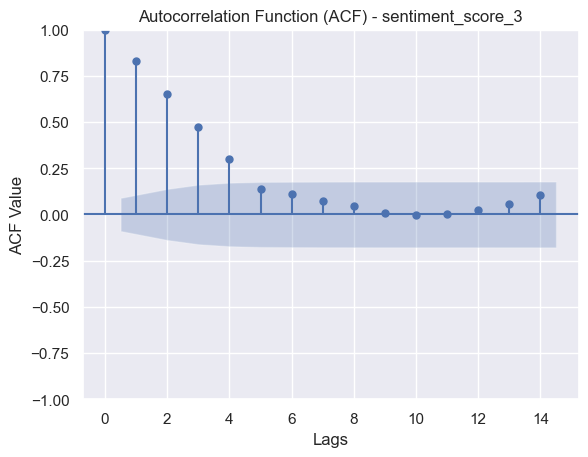

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -4.869958047390243
P-Value: 0.0003525757834224294
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


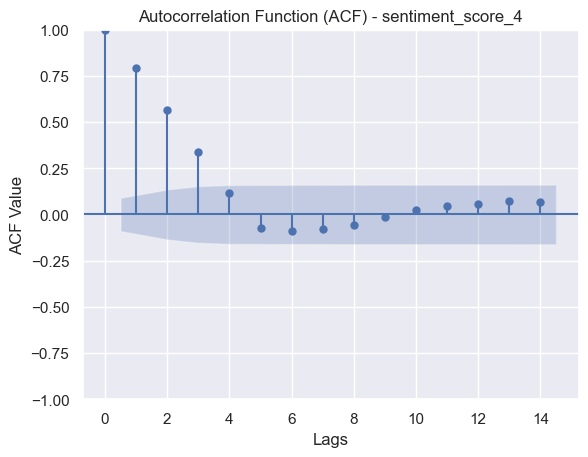

ADF Test Conclusion: Stationary
------------------------------------
ADF-Statistic: -5.100245227515646
P-Value: 0.00013460563422018984
Number of lags: 10
Number of observations: 467
Critical Values: {'1%': -3.978287320771828, '5%': -3.419933162931645, '10%': -3.132604833682177}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [161]:
for col in features_df.columns:
    check_stationarity(df, col, 14)

## Granger Causality Check

In [171]:
# Define helper function to check for granger causality
def check_granger_causality(df, target, features, maxlag, test='ssr_chi2test', conf_level=0.05):
    # Create dataframe to store confidence p-values
    granger_df = pd.DataFrame()
    granger_df['lag'] = [i for i in range(1,maxlag+1)]
    for feature in features:
        res = grangercausalitytests(df[[target, feature]], maxlag=maxlag)
        p_value = [res.get(i)[0].get(test)[1] for i in res.keys()]
        col_name = f'{feature}_causes_{target}'
        granger_df[col_name] = p_value

    # Plot chart of p-values against lag for each feature and target
    plt.figure(figsize=(16,9))
    for y in granger_df.columns[1:]:   
        plt.plot(granger_df['lag'],granger_df[y],linewidth=3, label=y)
    plt.axhline(conf_level, color='red', linestyle='-.')
    plt.xlabel('lag')
    plt.legend(loc='upper right')
    plt.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3780  , p=0.2410  , df_denom=473, df_num=1
ssr based chi2 test:   chi2=1.3867  , p=0.2390  , df=1
likelihood ratio test: chi2=1.3847  , p=0.2393  , df=1
parameter F test:         F=1.3780  , p=0.2410  , df_denom=473, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5957  , p=0.0757  , df_denom=470, df_num=2
ssr based chi2 test:   chi2=5.2466  , p=0.0726  , df=2
likelihood ratio test: chi2=5.2178  , p=0.0736  , df=2
parameter F test:         F=2.5957  , p=0.0757  , df_denom=470, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7434  , p=0.1573  , df_denom=467, df_num=3
ssr based chi2 test:   chi2=5.3086  , p=0.1505  , df=3
likelihood ratio test: chi2=5.2791  , p=0.1525  , df=3
parameter F test:         F=1.7434  , p=0.1573  , df_denom=467, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4731  , p=0.2092  

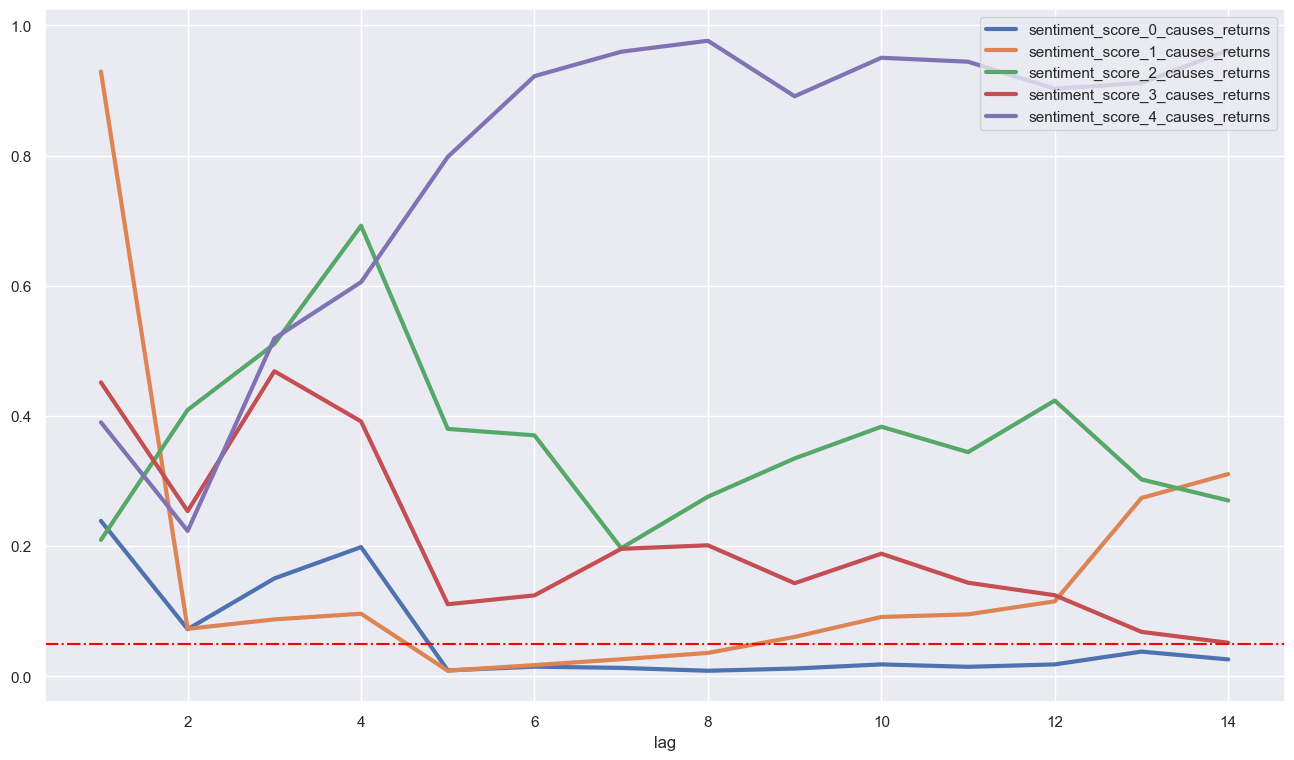

In [172]:
model_df = df.dropna()

# check granger causality of returns & sentiment scores
selected_target = 'returns'
selected_features = [col for col in features_df.columns if col.startswith('sentiment_score')]

check_granger_causality(model_df, selected_target, selected_features, 14)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8450  , p=0.3584  , df_denom=473, df_num=1
ssr based chi2 test:   chi2=0.8504  , p=0.3564  , df=1
likelihood ratio test: chi2=0.8496  , p=0.3567  , df=1
parameter F test:         F=0.8450  , p=0.3584  , df_denom=473, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3046  , p=0.1009  , df_denom=470, df_num=2
ssr based chi2 test:   chi2=4.6583  , p=0.0974  , df=2
likelihood ratio test: chi2=4.6356  , p=0.0985  , df=2
parameter F test:         F=2.3046  , p=0.1009  , df_denom=470, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4633  , p=0.2238  , df_denom=467, df_num=3
ssr based chi2 test:   chi2=4.4558  , p=0.2163  , df=3
likelihood ratio test: chi2=4.4349  , p=0.2182  , df=3
parameter F test:         F=1.4633  , p=0.2238  , df_denom=467, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4447  , p=0.2182  

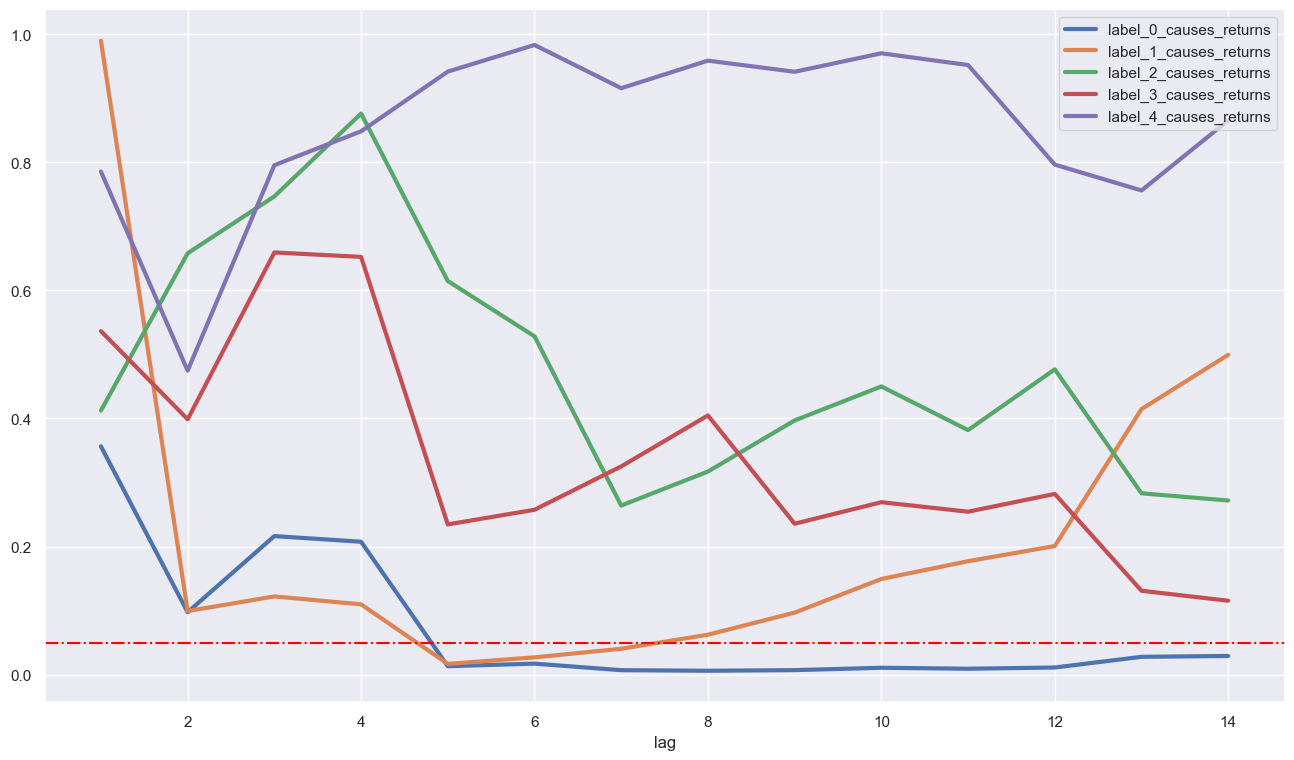

In [173]:
# check granger causality of returns & sentiment labels
selected_target = 'returns'
selected_features = [col for col in features_df.columns if col.startswith('label')]

check_granger_causality(model_df, selected_target, selected_features, 14)

## Lag Selection

In [183]:
# keep relevant columns
model_df = df.loc[:, ['returns', 'sentiment_score_0', 'sentiment_score_1']]
model_df.dropna(inplace=True)

VAR_model = VAR(model_df)
maxlag = 7

# for i in range(1,maxlag+1):
#     result = VAR_model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

results = VAR_model.fit(maxlags=7, ic='aic')
results.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 02, Aug, 2024
Time:                     02:12:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.1373
Nobs:                     471.000    HQIC:                  -23.4423
Log likelihood:           3619.28    FPE:                5.41122e-11
AIC:                     -23.6401    Det(Omega_mle):     4.80585e-11
--------------------------------------------------------------------
Results for equation returns
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.002070         0.002190           -0.945           0.345
L1.returns                  -0.010477         0.049733           -0.211           0.833
L1.sentiment_score_0        -0

In [184]:
# Select the optimal lag order
lag_order_selection = VAR_model.select_order(maxlags=7)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -20.38      -20.35   1.411e-09      -20.37
1      -23.29     -23.19*   7.649e-11      -23.25
2      -23.32      -23.13   7.489e-11      -23.24
3      -23.36      -23.10   7.159e-11      -23.26
4      -23.36      -23.02   7.162e-11      -23.22
5      -23.42      -22.99   6.758e-11      -23.25
6     -23.64*      -23.14  5.400e-11*     -23.44*
7      -23.63      -23.05   5.452e-11      -23.40
-------------------------------------------------


In [185]:
lags = range(1, 7)  # use up to 6 lags based on AIC

model_df = model_df.assign(**{
                f'{col} (t-{lag})': model_df[col].shift(lag)
                for lag in lags
                for col in model_df.columns[1:]
            })
model_df.head()

,returns,sentiment_score_0,sentiment_score_1,sentiment_score_0 (t-1),sentiment_score_1 (t-1),sentiment_score_0 (t-2),sentiment_score_1 (t-2),sentiment_score_0 (t-3),sentiment_score_1 (t-3),sentiment_score_0 (t-4),sentiment_score_1 (t-4),sentiment_score_0 (t-5),sentiment_score_1 (t-5),sentiment_score_0 (t-6),sentiment_score_1 (t-6)
date,,,,,,,,,,,,,,,
2022-07-08,0.004850,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-11,0.007898,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-12,-0.068524,-0.116865,-0.155559,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13,0.001776,-0.104410,-0.136242,-0.116865,-0.155559,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-14,0.005319,-0.117771,-0.140339,-0.104410,-0.136242,-0.116865,-0.155559,-0.115398,-0.149743,-0.087374,-0.154155,NaN,NaN,NaN,NaN


## Modelling

In [186]:
# Sort data by date
model_df.dropna(inplace=True)
model_df = model_df.sort_values('date')

# Split the data into train and test
train_set, test_set= np.split(model_df, [int(.67 *len(model_df))])
X_train, y_train = train_set.iloc[:, 1:], train_set.iloc[:, 0] 
X_test, y_test = test_set.iloc[:, 1:], test_set.iloc[:, 0] 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [70]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [71]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [72]:
arima = ARIMA(y_train, order=(5,1,0))
arima_fit = arima.fit()
y_pred_arima = arima_fit.forecast(steps=len(y_test))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarnin

In [73]:
arimax = SARIMAX(y_train, exog=X_train, order=(5,1,0))
arimax_fit = arimax.fit(disp=False)
y_pred_arimax = arimax_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

In [74]:
ada = AdaBoostRegressor(n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

In [75]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

models = {
    "Random Forest": y_pred_rf,
    "SVR": y_pred_svr,
    "ARIMA": y_pred_arima,
    "ARIMAX": y_pred_arimax,
    # "SVR-Li": y_pred_svr_li,
    "AdaBoost": y_pred_ada
}

for name, y_pred in models.items():
    mse, mae, r2 = evaluate_model(y_test, y_pred)
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Random Forest - MSE: 0.0003, MAE: 0.0141, R2: 0.0009
SVR - MSE: 0.0004, MAE: 0.0157, R2: -0.2437
ARIMA - MSE: 0.0004, MAE: 0.0165, R2: -0.3529
ARIMAX - MSE: 0.0004, MAE: 0.0147, R2: -0.1218
AdaBoost - MSE: 0.0003, MAE: 0.0140, R2: -0.0559


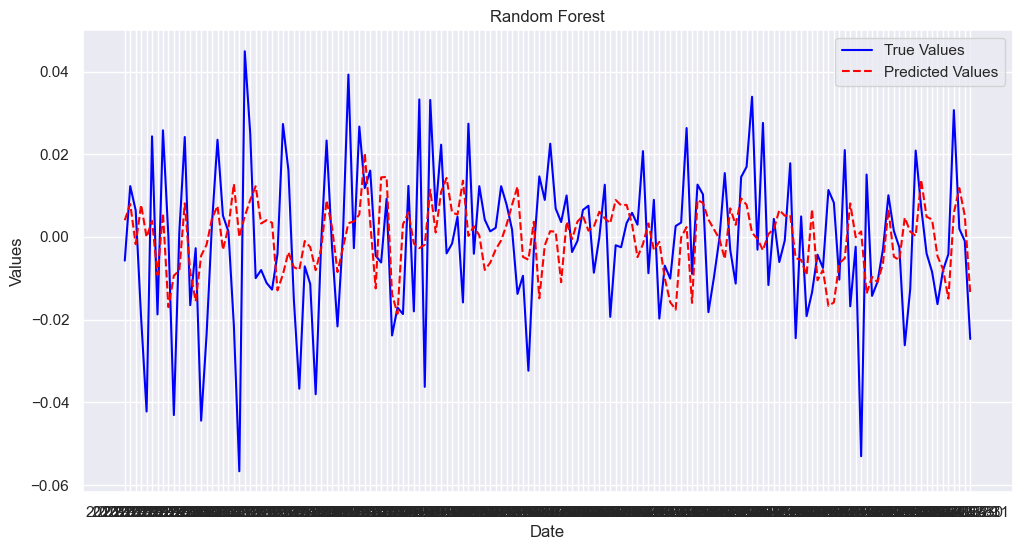

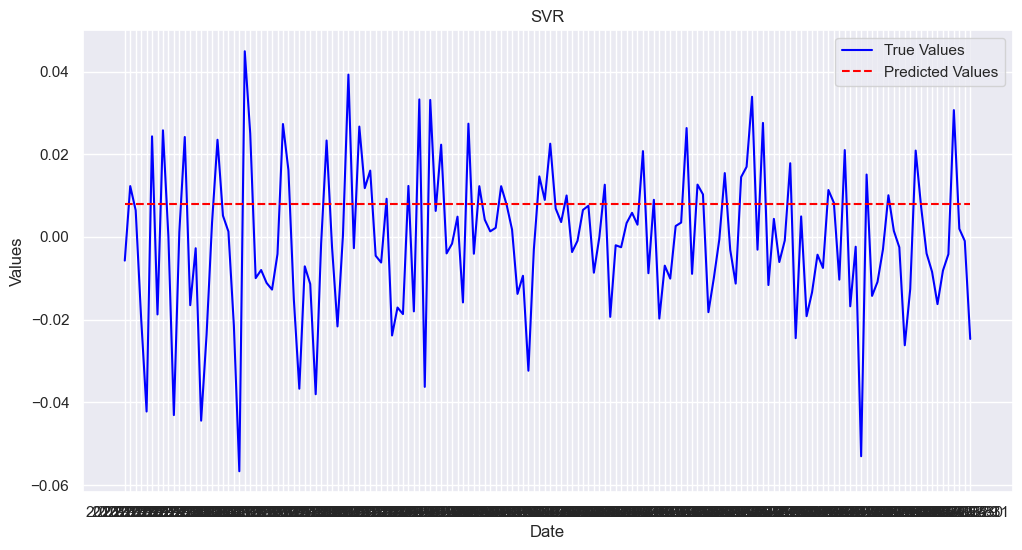

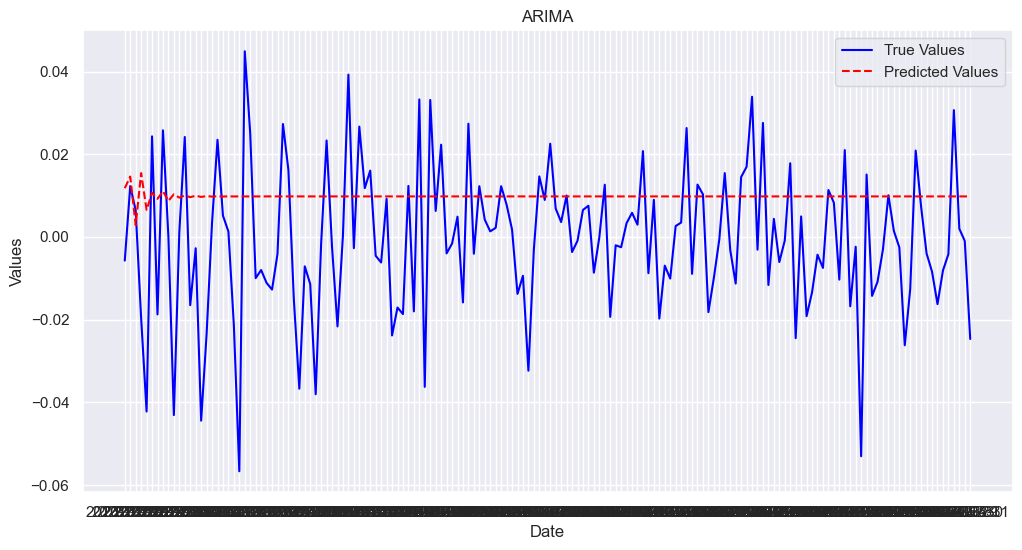

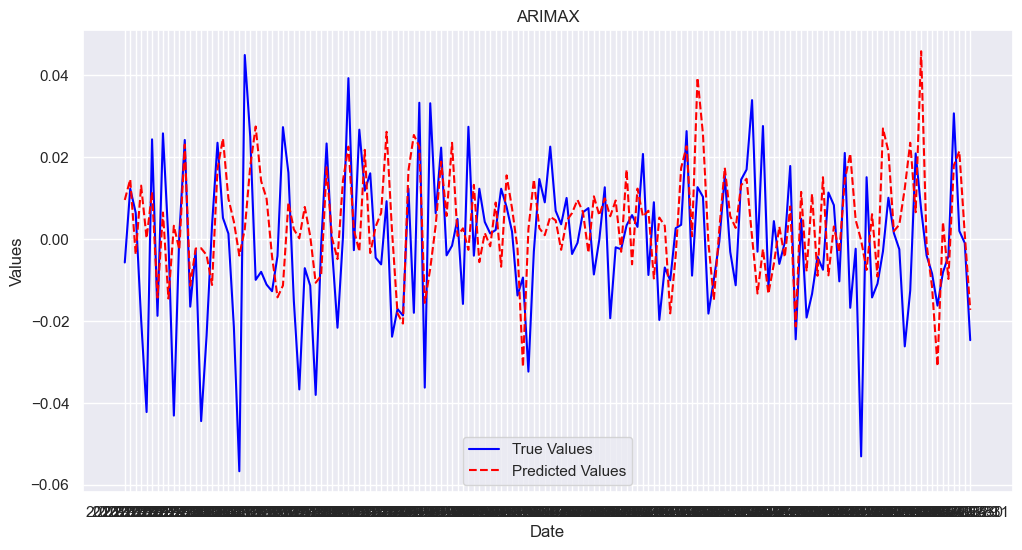

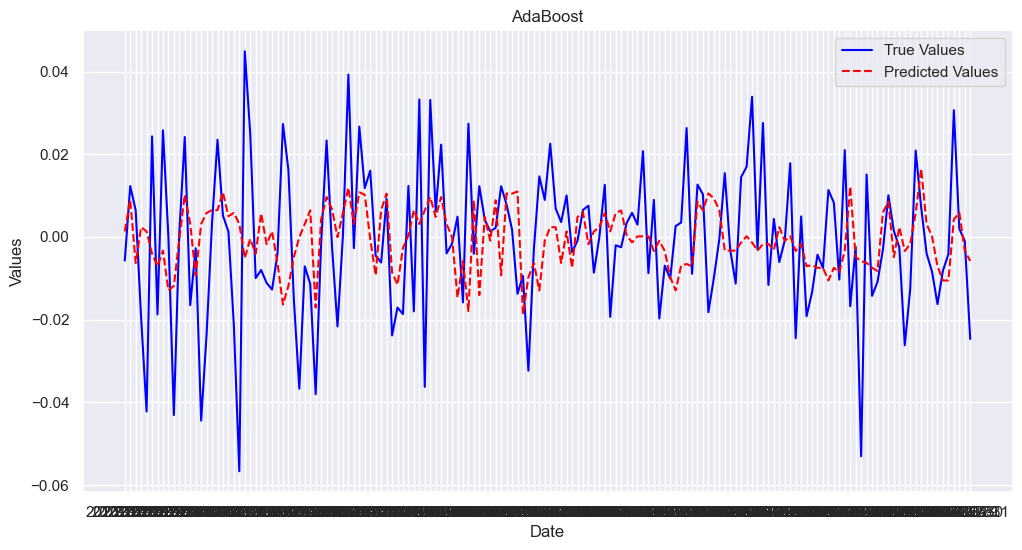

In [76]:
# Define a function to plot true vs. predicted values as line plots with a date index
def plot_true_vs_pred_line(dates, y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='True Values', color='blue')
    plt.plot(dates, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

y_test_dates = test_set.index
# Plotting the results for each model
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_rf, "Random Forest")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr, "SVR")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arima, "ARIMA")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_arimax, "ARIMAX")
# plot_true_vs_pred_line(y_test_dates, y_test, y_pred_svr_li, "SVR-Li")
plot_true_vs_pred_line(y_test_dates, y_test, y_pred_ada, "AdaBoost")


In [78]:
# save models
joblib.dump(rf, "models/random_forest.joblib")
joblib.dump(svr, 'models/svr.joblib')
joblib.dump(arima, 'models/arima.joblib')
joblib.dump(arimax, 'models/arimax.joblib')
joblib.dump(ada, 'models/adaboost_model.joblib')

['models/adaboost_model.joblib']